In [112]:
#from spx_analysis import simulate_market 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt
import yfinance  as yf
import seaborn as sns
from datetime import datetime as dt, timedelta

In [4]:
spx = pd.read_csv('^GSPC.csv', index_col=0)
spx.index = pd.to_datetime(spx.index).year
spx['daily_chg'] = np.log(spx['Adj Close']) - np.log(spx['Adj Close'].shift(1))

In [129]:
def hent_data(ticker="^OMXC20",start="1990-01-01"):
    '''
    Henter data fra yahoo-finance som har ticker=ticker og alle tilgængelig data efter start=start

    ticker (string): The ticker of the time series to be downloaded
    start (string): the start date of the time series to be downloaded

    returns:

    returns a dataframe with daily returns
    '''
    #Henter Data fra yahoo finance
    index = pd.DataFrame(yf.download(ticker, start=start, index_col=0))
    #Udregne afkast
    index['daily_chg'] = np.log(index['Adj Close']) - np.log(index['Adj Close'].shift(1))
    return index


## Simulating a market

In [321]:
years = 60

start_date = dt(2020, 1, 1)
end_date = dt(2080, 12, 31)
days = pd.date_range(start_date, end_date, freq='B')

# Random market
market = simulate_market(start_date, end_date, spx['daily_chg'][-20*252:]*100)
market.set_index(days, inplace=True)

# Annualizing returns
market = market.asfreq('Y', method='ffill', normalize=True)
market.index = market.index.year

15915


## Combining with investment profile

In [322]:
inv_plan = pd.read_csv('investment_plan.csv', sep=';', index_col=0)
market['Price'] = market['Price']*100/market['Price'].iloc[0]

In [323]:
def calculate_return(inv, market):
    assert len(inv) == len(market), 'Investment plan should be same no of periods as market' 
    inv['Roll_contribution'] = inv['Contributions'].cumsum()
    inv['Price'] = market['Price']
    inv['Account_value'] = 0
    inv['Total_debt'] = 0
    inv['New_debt'] = 0
    inv['Dollar_return'] = 0
    
    inv['Return'] = inv['Price'].pct_change()
    
    
    # Calculating debt
    for i in range(len(inv)):
        interest_rate = inv.iloc[i, 2]
        gearing = inv.iloc[i, 0]
        cont = inv.iloc[i, 1]
        new_debt = max(gearing-1, 0)*cont
        inv.iloc[i, 7] = new_debt
        
        # Calculating interest and total debt
        if i > 0:
            previous_debt = inv.iloc[i-1, 6]
            accrued_interest = previous_debt*(1+interest_rate)
        else:
            accrued_interest = 0
        
        total_debt = new_debt + accrued_interest
        inv.iloc[i, 6] = total_debt
    
        # Calculating total return
        if i == 0:
            account_value = new_debt + cont
        else:
            previous_account_value = inv.iloc[i-1, 5]
            period_return = inv.iloc[i, 9]
            account_value = (previous_account_value + (new_debt + cont))*(1+period_return)
        

        inv.iloc[i, 5] = account_value
        # Dollar return net debt
        inv.iloc[i, 8] = account_value - total_debt


    return inv

In [324]:
port = calculate_return(inv_plan, market)

Text(0.5, 1.0, 'Portfolio contributions')

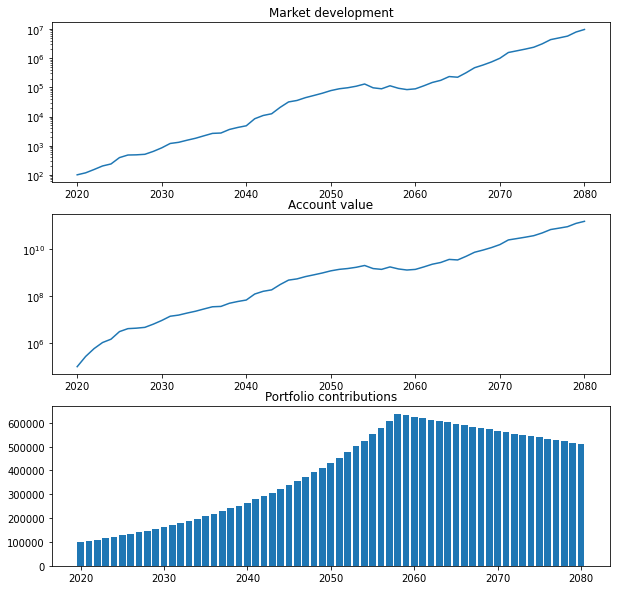

In [325]:
fig,ax = plt.subplots(3, 1, figsize=(10, 10))
ax[0].plot(port['Price'])
ax[0].set_title('Market development')
ax[0].set_yscale('log')
ax[1].plot(port['Dollar_return'])
ax[1].set_title('Account value')
ax[1].set_yscale('log')
ax[2].bar(height=port['Contributions'], x=port.index)
ax[2].set_title('Portfolio contributions')

## Plotting Real Market data

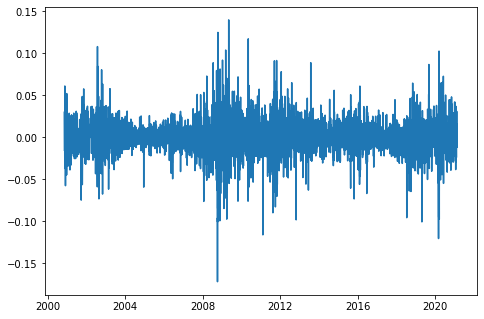

In [164]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.plot(index["daily_chg"])
plt.show()

In [163]:
index=hent_data('DANSKE.CO',"2000-01-01")
index.tail(10)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,daily_chg
Date,,,,,,,
2021-02-11,109.650002,110.150002,108.599998,109.750000,109.750000,1136245,-0.000456
2021-02-12,109.750000,110.000000,109.000000,109.699997,109.699997,1280444,-0.000456
2021-02-15,110.699997,113.300003,110.349998,113.150002,113.150002,2244214,0.030965
2021-02-16,113.300003,114.199997,112.699997,113.300003,113.300003,1403055,0.001325
2021-02-17,113.199997,113.550003,111.800003,112.699997,112.699997,1185985,-0.005310
2021-02-18,112.150002,113.300003,111.050003,111.349998,111.349998,1355295,-0.012051
2021-02-19,111.750000,113.550003,111.199997,113.150002,113.150002,2202428,0.016036
2021-02-22,113.500000,113.650002,112.300003,113.500000,113.500000,1202288,0.003088
2021-02-23,113.349998,114.199997,110.349998,113.300003,113.300003,2408280,-0.001764
